In [ ]:
import numpy as np
import pandas as pd
import glob

pd.options.display.float_format = '{:.4f}'.format

# Seed
np.random.seed(480)


# Load Clean Data
file_list = glob.glob("data/clean_*.csv") # ['data/split_1.csv', ... ,'data/split_5.csv']

df = pd.concat([pd.read_csv(file) for file in file_list], # list comprehension, supposedly faster than for loop
               ignore_index=True
               )

In [ ]:
factor_cols = [
    'CRASH_DATE_EST_I',
    #'POSTED_SPEED_LIMIT', 
    'TRAFFIC_CONTROL_DEVICE', 
    'DEVICE_CONDITION', 
    'WEATHER_CONDITION', 
    'LIGHTING_CONDITION', 
    'FIRST_CRASH_TYPE', ##### attention to this one! what to do?? keep in x?
    'TRAFFICWAY_TYPE', 
    'ALIGNMENT', 
    'ROADWAY_SURFACE_COND', 
    'ROAD_DEFECT', 
    'REPORT_TYPE', 
    'CRASH_TYPE', 
    'INTERSECTION_RELATED_I',
    'NOT_RIGHT_OF_WAY_I',
    'HIT_AND_RUN_I',
    'DAMAGE', ### attention to this one! potential response var??
    'PRIM_CONTRIBUTORY_CAUSE', 
    'SEC_CONTRIBUTORY_CAUSE',  
    'DOORING_I',
    'WORK_ZONE_I',
    'WORK_ZONE_TYPE', ### > 99% are N/A
    'WORKERS_PRESENT_I',
    'MOST_SEVERE_INJURY', 
    'CRASH_HOUR', 
    'CRASH_DAY_OF_WEEK', 
    'CRASH_MONTH',
    'Crash_Year', # Recently Incuded #
    'Police_district', # Recently Inc, using instead of 'BEAT_OF_OCCURRENCE'
    'LANE_CNT', # Recently Incuded #
]

# Convert to categorical
for col in factor_cols:
    df[col] = df[col].astype('category')



# 5 variables not useful for predictive analysis
not_usefull = ['CRASH_RECORD_ID', 
               'BEAT_OF_OCCURRENCE',
               'STREET_NO', 
               'STREET_DIRECTION', 
               'STREET_NAME',
               'LATITUDE', 
               'LONGITUDE',
               ]


# 2 Date variables
date_vars = ['CRASH_DATE', 
             'DATE_POLICE_NOTIFIED',
             ] # using Report_vs_Police_Notified: hours between crash and notification


# 8 potential response variables
responses = ['CRASH_TYPE', #1
             'MOST_SEVERE_INJURY', #2
             'INJURIES_TOTAL', #3
             'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
             #'DAMAGE',
             ]

### Binomial Logistic Regression


In [ ]:
import patsy

# Binary response variable
response = 'CRASH_TYPE' # 2 classes: NO INJURY | INJURY and/or Towed due to crash

predictors = df.drop(columns=responses+not_usefull+date_vars).columns

formula = f"{response} ~ {' + '.join(predictors)}"

_, X = patsy.dmatrices(formula, data = df, return_type='dataframe')
y = df[response]

In [ ]:
import os

# Number of CPU cores available
num_cores = os.cpu_count()  # or multiprocessing.cpu_count()

print("Total CPU cores available:", num_cores)

Total CPU cores available: 8


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


lasso_logistic = LogisticRegressionCV(
    penalty='l1',
    solver='saga',  # SAGA supports L1 regularization, faster for large datasets & Multi-class/Multinomial
    cv=5, 
    max_iter=1000,
    tol=1e-3,
    random_state=480,
    Cs=10,  # Number of lambda values,
    n_jobs=-1,  # Use all processors -1
)

lasso_logistic.fit(X, y)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=7, penalty='l1',
                     random_state=480, solver='saga', tol=0.001)

In [ ]:
print("Best Lambda:", 1 / lasso_logistic.C_[0])  # Regularization strength (lambda = 1 / C)
print("Coef. shape: ", lasso_logistic.coef_.shape)  # (1, p) for binary response

Best Lambda: 21.544346900318843


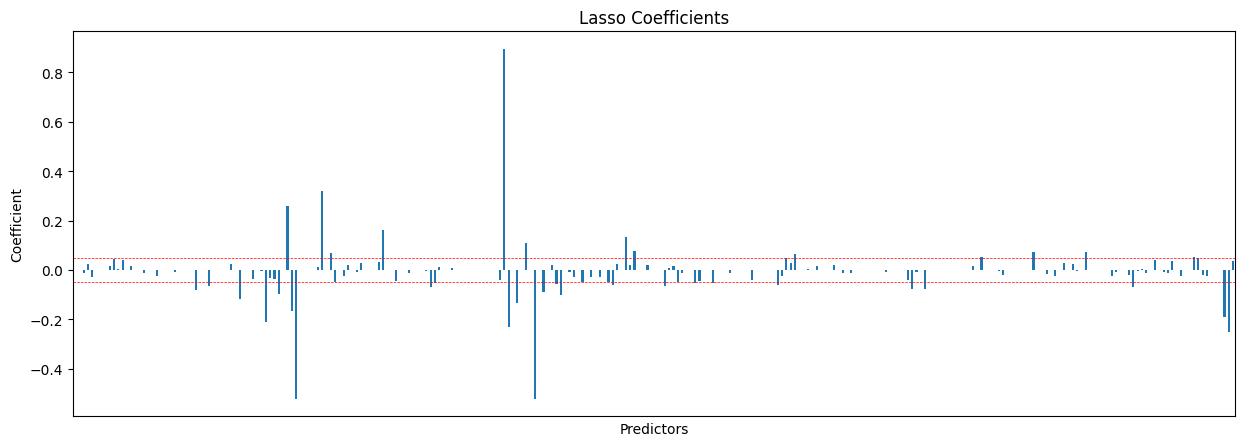

In [ ]:
coef_df = pd.DataFrame(
    lasso_logistic.coef_.T,
    index = X.columns, 
    )

#coef_df[abs(coef_df) < 1e-4] = "." 

# Get coeffs bigger than arbitrary threshold: 0.05
threshold = 5e-2
coef_df[coef_df.abs()>threshold].dropna()

## Plot
coef_df.plot.bar(figsize=(15, 5),
                 title="Lasso Coefficients", xlabel="Predictors", ylabel="Coefficient",
                 legend=False, xticks=[],
                 )

import matplotlib.pyplot as plt
plt.axhline(threshold, color='r', linestyle='--', linewidth=0.5)
plt.axhline(-threshold, color='r', linestyle='--', linewidth=0.5)
plt.show()